In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
h = cosmos.H0.value/100
from Corrfunc.mocks import DDrppi_mocks, DDtheta_mocks
from Corrfunc.io import read_catalog
from Corrfunc.theory import DDrppi, DD
from my_util import convert_rp_pi_counts_to_wp
from astropy.io import fits
from sklearn.neighbors import BallTree

In [2]:
quasar = np.load('../catalogue/quasar_lss_all.npy')
random = np.load('../catalogue/random_quasar_lss_all.npy')

In [3]:
dis_cov_q = cosmos.angular_diameter_distance(quasar['z']).to(u.Mpc).value*(1+quasar['z'])*h
dis_cov_r = cosmos.angular_diameter_distance(random['z']).to(u.Mpc).value*(1+random['z'])*h

In [30]:
Nbins = 15
rp_min = 3
rp_max = 100
rp_bin = np.geomspace(rp_min, rp_max, Nbins+1)
r_p = (rp_bin[:-1]*rp_bin[1:])**0.5

z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)

theta_bins = rp_bin/h/(1+z)/d_A
theta_bins_deg = np.rad2deg(theta_bins)

pimax = 100

In [41]:
quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
tree = BallTree(data=np.deg2rad(np.c_[quasar_SDSS['DEC'], quasar_SDSS['RA']]),
                leaf_size=5, metric='haversine')
# tree = KDTree(np.c_[quasar_SDSS['RA'], quasar_SDSS['DEC']], metric='euclidean')
que = tree.query(np.deg2rad(np.c_[quasar['dec'], quasar['ra']]))
valid = que[0].flatten() < .5/3600*np.pi/180
index = que[1].flatten()

M_I = quasar_SDSS['M_I'][index]
M_I[~valid] = np.nan
bins = np.linspace(0.8, 2.2, 30)            # the z cut applied to quasar lss all
result = np.digitize(quasar['z'], bins)
kind = np.zeros(len(quasar), int)
middles = []
high = []
low = []
for i in range(1, 30):
    index = np.where(result == i)[0]
    M = M_I[index]
    middle = np.percentile(M[~np.isnan(M)], 50)
    high.append(index[M <= middle])
    low.append(index[M >= middle])

index_h = np.concatenate(high)
index_l = np.concatenate(low)

In [42]:
quasar_sub = quasar[index_h]
distance_sub = dis_cov_q[index_h]

Nd = len(quasar_sub['w'])
Nr = len(random)
wei_norm = quasar_sub['w'] / (quasar_sub['w'].mean())

dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, is_comoving_dist=True, weight_type='pair_product')
rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True, weight_type='pair_product')
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
    RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True, weight_type='pair_product')

w_h = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

In [43]:
quasar_sub = quasar[index_l]
distance_sub = dis_cov_q[index_l]

Nd = len(quasar_sub['w'])
wei_norm = quasar_sub['w'] / (quasar_sub['w'].mean())

dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, is_comoving_dist=True, weight_type='pair_product')
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
    RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True, weight_type='pair_product')

w_l = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

In [44]:
with open('./auto_corrs/auto_corr_corrfunc_h.npy', 'wb') as f:
    np.save(f, r_p)
    np.save(f, w_h)

with open('./auto_corrs/auto_corr_corrfunc_l.npy', 'wb') as f:
    np.save(f, r_p)
    np.save(f, w_l)

result of $w(r_p)$

In [45]:
quasar_sub = quasar
distance_sub = dis_cov_q

Nd = quasar_sub['w'].sum()
Nr = len(random)
wei_norm = quasar_sub['w']

dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, is_comoving_dist=True, weight_type='pair_product')
rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=random['ra'], DEC1=random['dec'], CZ1=dis_cov_r, weights1=random['w'], is_comoving_dist=True, weight_type='pair_product')
dr = DDrppi_mocks(
    autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
    RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=distance_sub, weights1=wei_norm, 
    RA2=random['ra'], DEC2=random['dec'], CZ2=dis_cov_r, weights2=random['w'], 
    is_comoving_dist=True, weight_type='pair_product')

wp = convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

In [46]:
with open('./auto_corrs/auto_corr_corrfunc.npy', 'wb') as f:
    np.save(f, r_p)
    np.save(f, wp)

[]

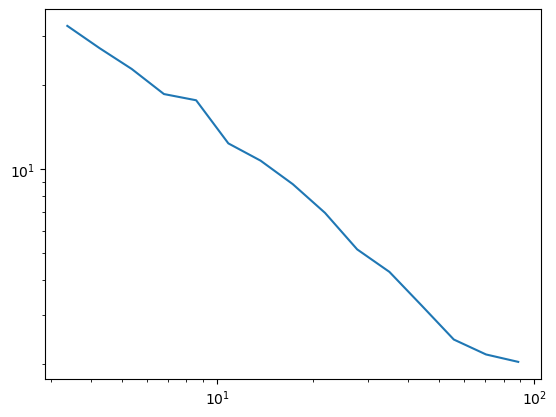

In [ ]:
plt.plot(r_p, wp)
plt.loglog()

Jackknife (run this in a `.py` file)

In [ ]:
# import healpy as hp
# Nside_jack = 10
# c = coo.SkyCoord(ra=quasar['ra']*u.degree, dec=quasar['dec']*u.degree)

# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# npix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
# c = coo.SkyCoord(ra=random['ra']*u.degree, dec=random['dec']*u.degree)

# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# npix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
# pix = np.unique(npix)

with open('label.bin', 'rb') as f:
    npix = np.load(f)
    npix_r = np.load(f)
pix = np.unique(npix)
def resample(p, sender):
    sub_sample = npix != p
    sub_sample_r = npix_r != p

    quasar_sub = quasar[sub_sample]
    random_sub = random[sub_sample_r]

    dd = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                   RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    rr = DDrppi_mocks(autocorr=True, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin,
                    RA1=random_sub['ra'], DEC1=random_sub['dec'], CZ1=dis_cov_r[sub_sample_r], weights1=random_sub['w'], is_comoving_dist=True, weight_type='pair_product')
    dr = DDrppi_mocks(
        autocorr=False, cosmology=1, nthreads=50, pimax=pimax, binfile=rp_bin, 
        RA1=quasar_sub['ra'], DEC1=quasar_sub['dec'], CZ1=dis_cov_q[sub_sample], weights1=quasar_sub['w'], 
        RA2=random_sub['ra'], DEC2=random_sub['dec'], CZ2=dis_cov_r[sub_sample_r], weights2=random_sub['w'], 
        is_comoving_dist=True, weight_type='pair_product')

    Nd = len(quasar_sub)
    Nr = len(random_sub)
    sender.send(1)
    return convert_rp_pi_counts_to_wp(Nd, Nd, Nr, Nr, dd, dr, dr, rr, pimax=pimax, nrpbins=Nbins)

def progress_bar(Ntotal, receiver, rate=10):
    # rate is the update rate of the progress bar.
    rate = max(1, int(rate))
    with tqdm(total=int(Ntotal/rate)) as pbar:
        count = 0
        while True:
            if receiver.recv():
                count += 1
                if count % rate == 0:
                    pbar.update(1)
            else:
                break
        pbar.close()
from itertools import repeat
sender, recv = mp.Pipe()

pool = mp.Pool(5)

bar = mp.Process(target=progress_bar, args=(len(pix), recv, 1))
bar.start()
w_arr = np.vstack(list(tqdm(pool.starmap(resample, zip(pix, repeat(sender))))))
sender.send(0)
bar.join()

np.save('auto_corr_jackknife_kmeans_100', w_arr)

New jackknife result

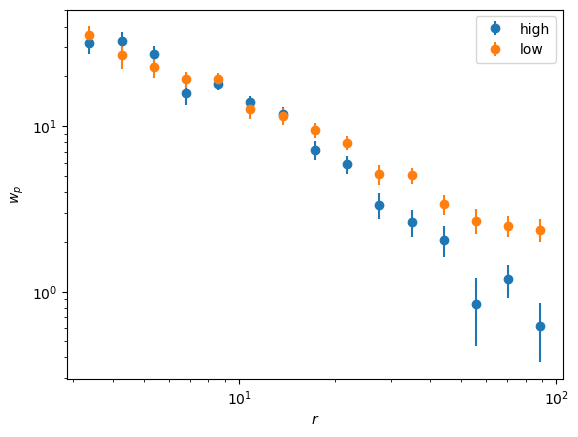

In [ ]:
w_arr_h = np.load('auto_corr_jackknife_kmeans_100_high.npy')
val_h = w_arr_h.mean(axis=0)
std_h = w_arr_h.std(axis=0, ddof=0) * np.sqrt(w_arr_h.shape[0] - 1)

w_arr_l = np.load('auto_corr_jackknife_kmeans_100_low.npy')
val_l = w_arr_l.mean(axis=0)
std_l = w_arr_l.std(axis=0, ddof=0) * np.sqrt(w_arr_l.shape[0] - 1)

Nbins = 15
rp_min = 3
rp_max = 100
rp_bin = np.geomspace(rp_min, rp_max, Nbins+1)
r_p = (rp_bin[:-1]*rp_bin[1:])**0.5
plt.errorbar(r_p, val_h, std_h, fmt='o', label='high')
plt.errorbar(r_p, val_l, std_l, fmt='o', label='low')
plt.loglog()
plt.legend()
plt.xlabel('$r$')
plt.ylabel('$w_p$')
plt.show()

Compare with pycorr

[]

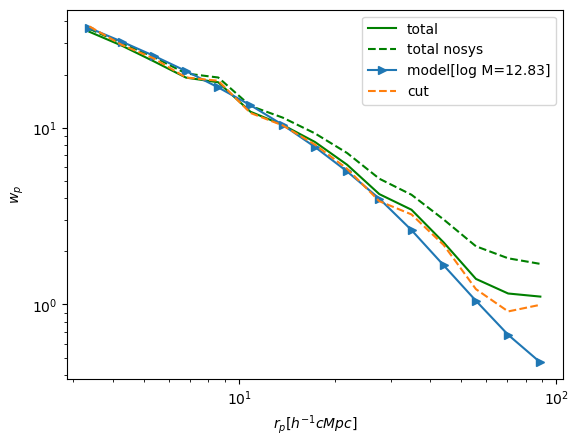

In [50]:
import os
os.chdir('./auto_corrs')

with open('auto_corr_corrfunc_h.npy', 'rb') as f:
    rp = np.load(f)
    wp_corrfunc_h = np.load(f)
with open('auto_corr_corrfunc_l.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_l = np.load(f)

with open('auto_corr_corrfunc_h_nosys.npy', 'rb') as f:
    rp = np.load(f)
    wp_corrfunc_h_nosys = np.load(f)
with open('auto_corr_corrfunc_l_nosys.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_l_nosys = np.load(f)

with open('auto_corr_corrfunc.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc = np.load(f)
with open('auto_corr_corrfunc_nosys.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_nosys = np.load(f)
with open('auto_corr_corrfunc_cut.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_c = np.load(f)

wp_thoery = np.load('predict.npy')[:,1]

os.chdir('..')
# plt.plot(rp, wp_corrfunc_h, 'r-', label='h')
# plt.plot(rp, wp_corrfunc_l, 'b-', label='l')
plt.plot(rp, wp_corrfunc, 'g-', label='total')

# plt.plot(rp, wp_corrfunc_h_nosys, 'r--', label='h nosys')
# plt.plot(rp, wp_corrfunc_l_nosys, 'b--', label='l nosys')
plt.plot(rp, wp_corrfunc_nosys, 'g--', label='total nosys')
plt.plot(rp, wp_thoery, '>-', label='model[log M=12.83]')
plt.plot(rp, wp_corrfunc_c, '--', label='cut')

lgMmin=12.833

plt.xlabel('$r_p[h^{-1}cMpc]$')
plt.ylabel('$w_p$')

plt.legend()
plt.loglog()

In [5]:
wp_thoery

array([36.66303556, 30.74253224, 25.5370701 , 20.93084881, 16.91174551,
       13.41365627, 10.38983507,  7.79075208,  5.65924884,  3.97161238,
        2.63545555,  1.66420362,  1.04935242,  0.67344041,  0.4699157 ])

In [ ]:
import os
os.chdir('./auto_corrs')

with open('auto_corr_pycorr_h.npy', 'rb') as f:
    rp = np.load(f)
    wp_pycorr_h = np.load(f)
with open('auto_corr_pycorr_l.npy', 'rb') as f:
    _ = np.load(f)
    wp_pycorr_l = np.load(f)

with open('auto_corr_corrfunc_h.npy', 'rb') as f:
    rp = np.load(f)
    wp_corrfunc_h = np.load(f)
with open('auto_corr_corrfunc_l.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_l = np.load(f)

with open('auto_corr_corrfunc_h_nosys.npy', 'rb') as f:
    rp = np.load(f)
    wp_corrfunc_h_nosys = np.load(f)
with open('auto_corr_corrfunc_l_nosys.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc_l_nosys = np.load(f)


with open('auto_corr_pycorr.npy', 'rb') as f:
    rp = np.load(f)
    wp_pycorr = np.load(f)
with open('auto_corr_corrfunc.npy', 'rb') as f:
    _ = np.load(f)
    wp_corrfunc = np.load(f)

In [ ]:
sig = np.load('../../mcmc/python/signal.npy')

In [ ]:
wp_corrfunc

array([34.92441395, 29.18659115, 23.80287855, 19.22331517, 18.09225082,
       12.31890152, 10.38794283,  8.32353077,  6.18772307,  4.22007572,
        3.44023561,  2.24824481,  1.40176183,  1.15746306,  1.11112869])

In [ ]:
sig[1]

array([40.79658662, 34.28736229, 28.0273113 , 22.83118371, 21.56307195,
       15.0358564 , 12.81478661, 10.49017615,  8.06773307,  5.8375764 ,
        4.9705894 ,  3.63010058,  2.67371212,  2.40559168,  2.36511232])

[]

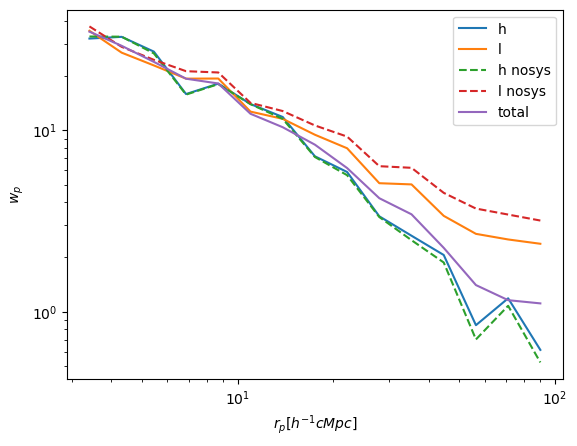

In [ ]:
assert np.isclose(wp_pycorr_h, wp_corrfunc_h).all()
assert np.isclose(wp_pycorr_l, wp_corrfunc_l).all()
assert np.isclose(wp_pycorr, wp_corrfunc).all()


plt.plot(rp, wp_corrfunc_h, '-', label='h')
plt.plot(rp, wp_corrfunc_l, '-', label='l')

plt.plot(rp, wp_corrfunc_h_nosys, '--', label='h nosys')
plt.plot(rp, wp_corrfunc_l_nosys, '--', label='l nosys')

plt.plot(rp, wp_corrfunc, label='total')
plt.xlabel('$r_p[h^{-1}cMpc]$')
plt.ylabel('$w_p$')

plt.legend()
plt.loglog()

[]

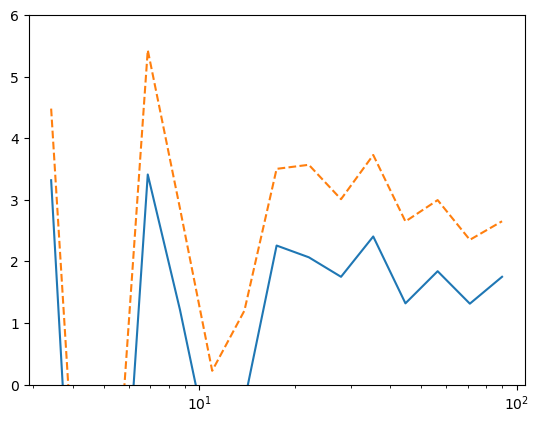

In [ ]:
plt.plot(rp, wp_corrfunc_l - wp_corrfunc_h)
plt.plot(rp, wp_corrfunc_l_nosys - wp_corrfunc_h_nosys, '--')
# plt.plot(rp, w_l - w_h)
# plt.plot(rp, (w_l - w_h) / (wp_corrfunc_l - wp_corrfunc_h), '--')
plt.ylim(bottom=0)
plt.semilogx()

In [ ]:
import seaborn as sns

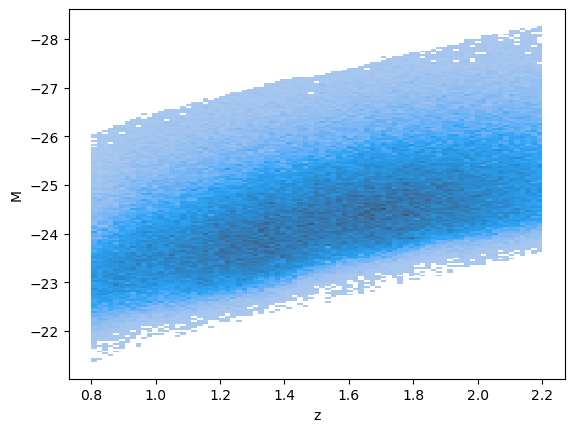

In [ ]:
ax = sns.histplot({'z': quasar['z'], 'M': M_I.astype(float)}, x='z', y='M')
ax.invert_yaxis()